In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt

In [2]:
place = 'Pyongyang, North Korea'
local_crs = 5179

In [3]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})

/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/geometries.py:816: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_inner_linestring in list(merged_inner_linestrings):
/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/geometries.py:816: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_

In [4]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [5]:
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings["uID"] = range(len(buildings))

In [6]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')

/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [7]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [8]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [9]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [10]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/andrewrenninger/anaconda3/envs/sdsc/lib/python3.9/site-packages/momepy/elements.py:394: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [10966, 2614, 14070, 4940, 2757, 78, 6548, 1521, 4925, 2598, 7901, 14139, 2382, 15567, 10773]
  warnings.warn(


In [11]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [12]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [13]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

In [14]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

In [15]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

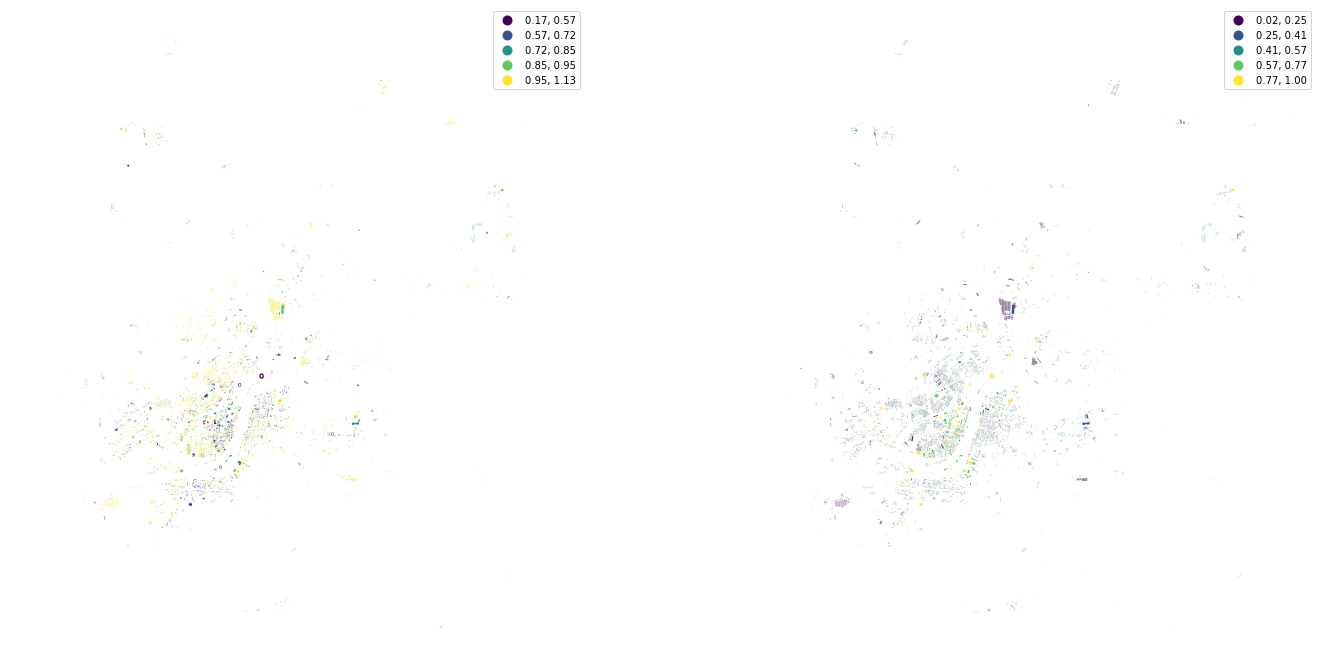

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_64800/1795271824.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  north, south, east, west = osmnx.utils_geo.bbox_from_point((buildings.geometry.to_crs("epsg:4326").centroid.y.mean(),
/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_64800/1795271824.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings.geometry.to_crs("epsg:4326").centroid.x.mean()),


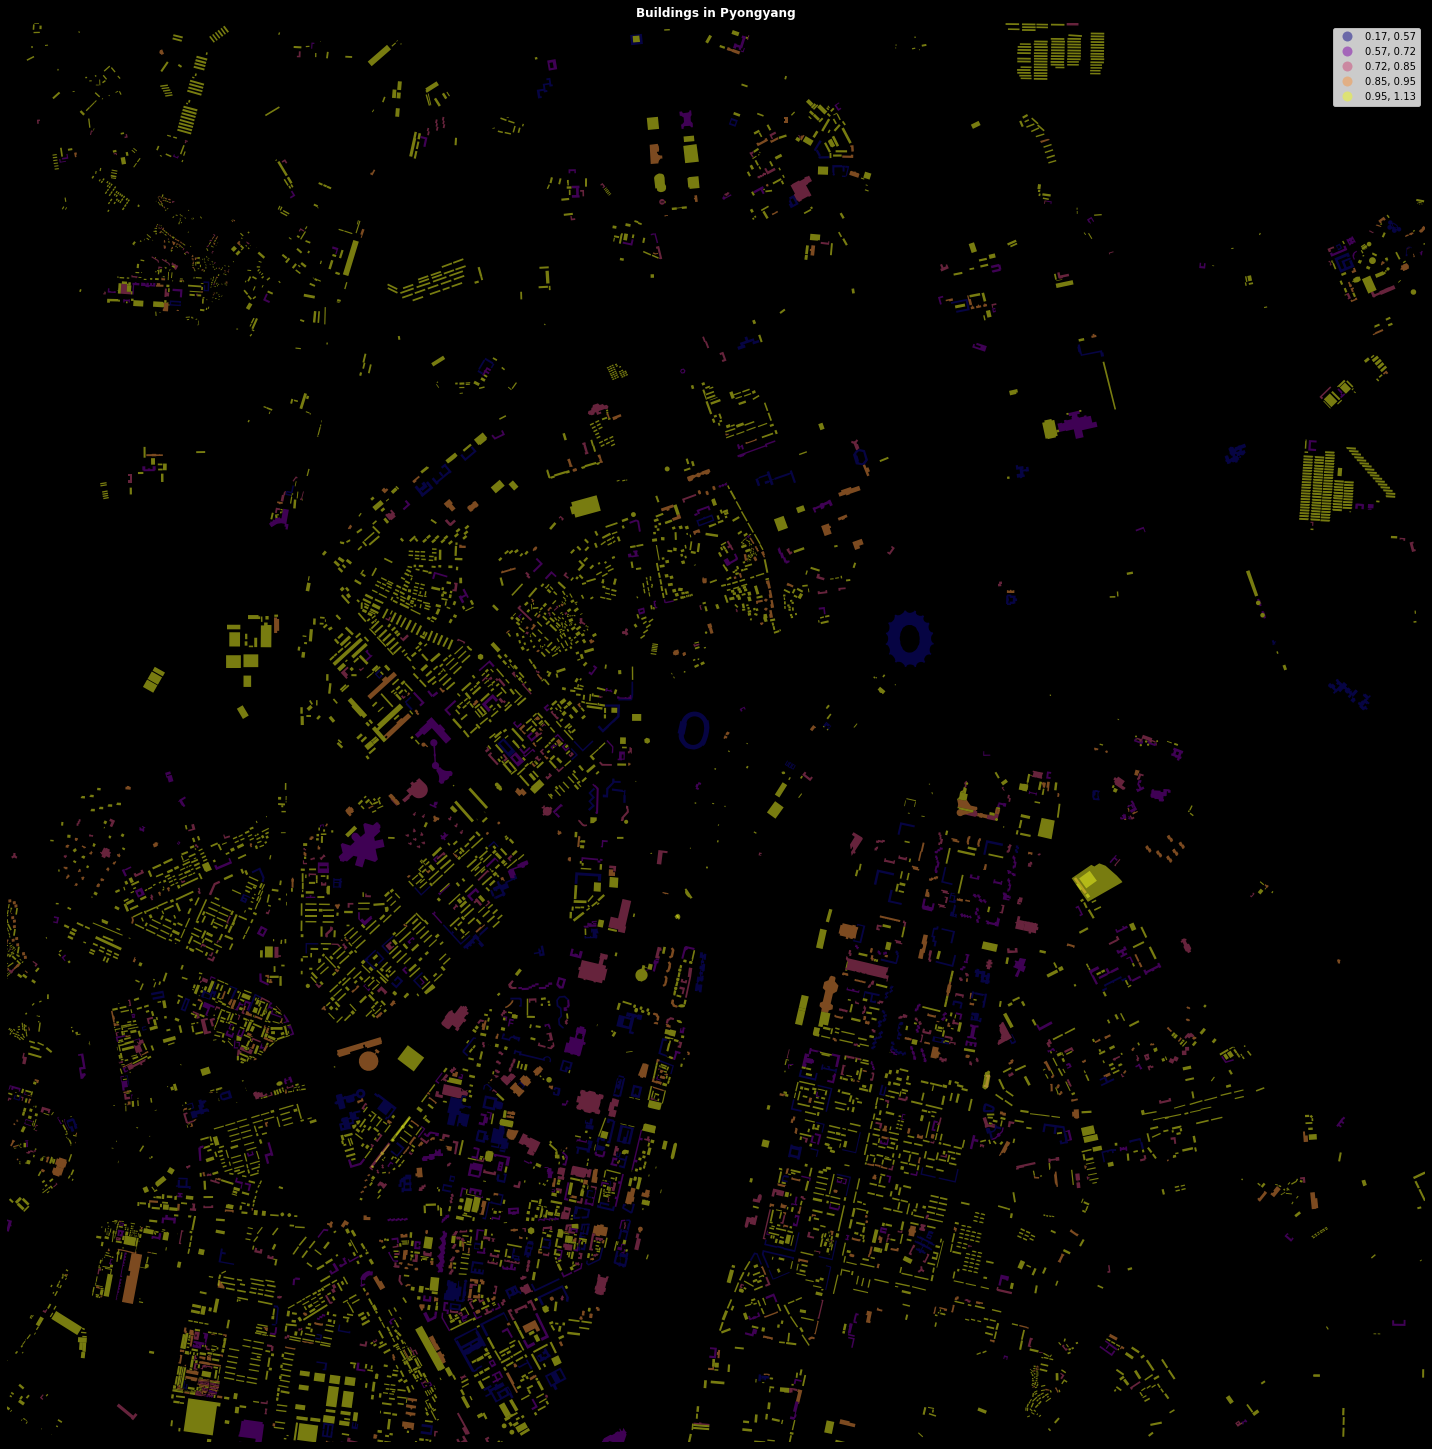

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

buildings.to_crs("epsg:4326").plot("eri", ax=ax, cmap='plasma', alpha=0.5, scheme="natural_breaks", legend=True)
    
ax.set_title("Buildings in Pyongyang", color='w', weight='bold')

north, south, east, west = osmnx.utils_geo.bbox_from_point((buildings.geometry.to_crs("epsg:4326").centroid.y.mean(), 
                                                            buildings.geometry.to_crs("epsg:4326").centroid.x.mean()), 
                                                           dist=5000, project_utm=False, return_crs=False)

ax.set_ylim((south, north))
ax.set_xlim((west, east))

ax.margins(0)
ax.axis('off')
    
fig.savefig('urban-morphology-pyongyang-eri.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_64800/1700770482.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  north, south, east, west = osmnx.utils_geo.bbox_from_point((buildings.geometry.to_crs("epsg:4326").centroid.y.mean(),
/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_64800/1700770482.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings.geometry.to_crs("epsg:4326").centroid.x.mean()),


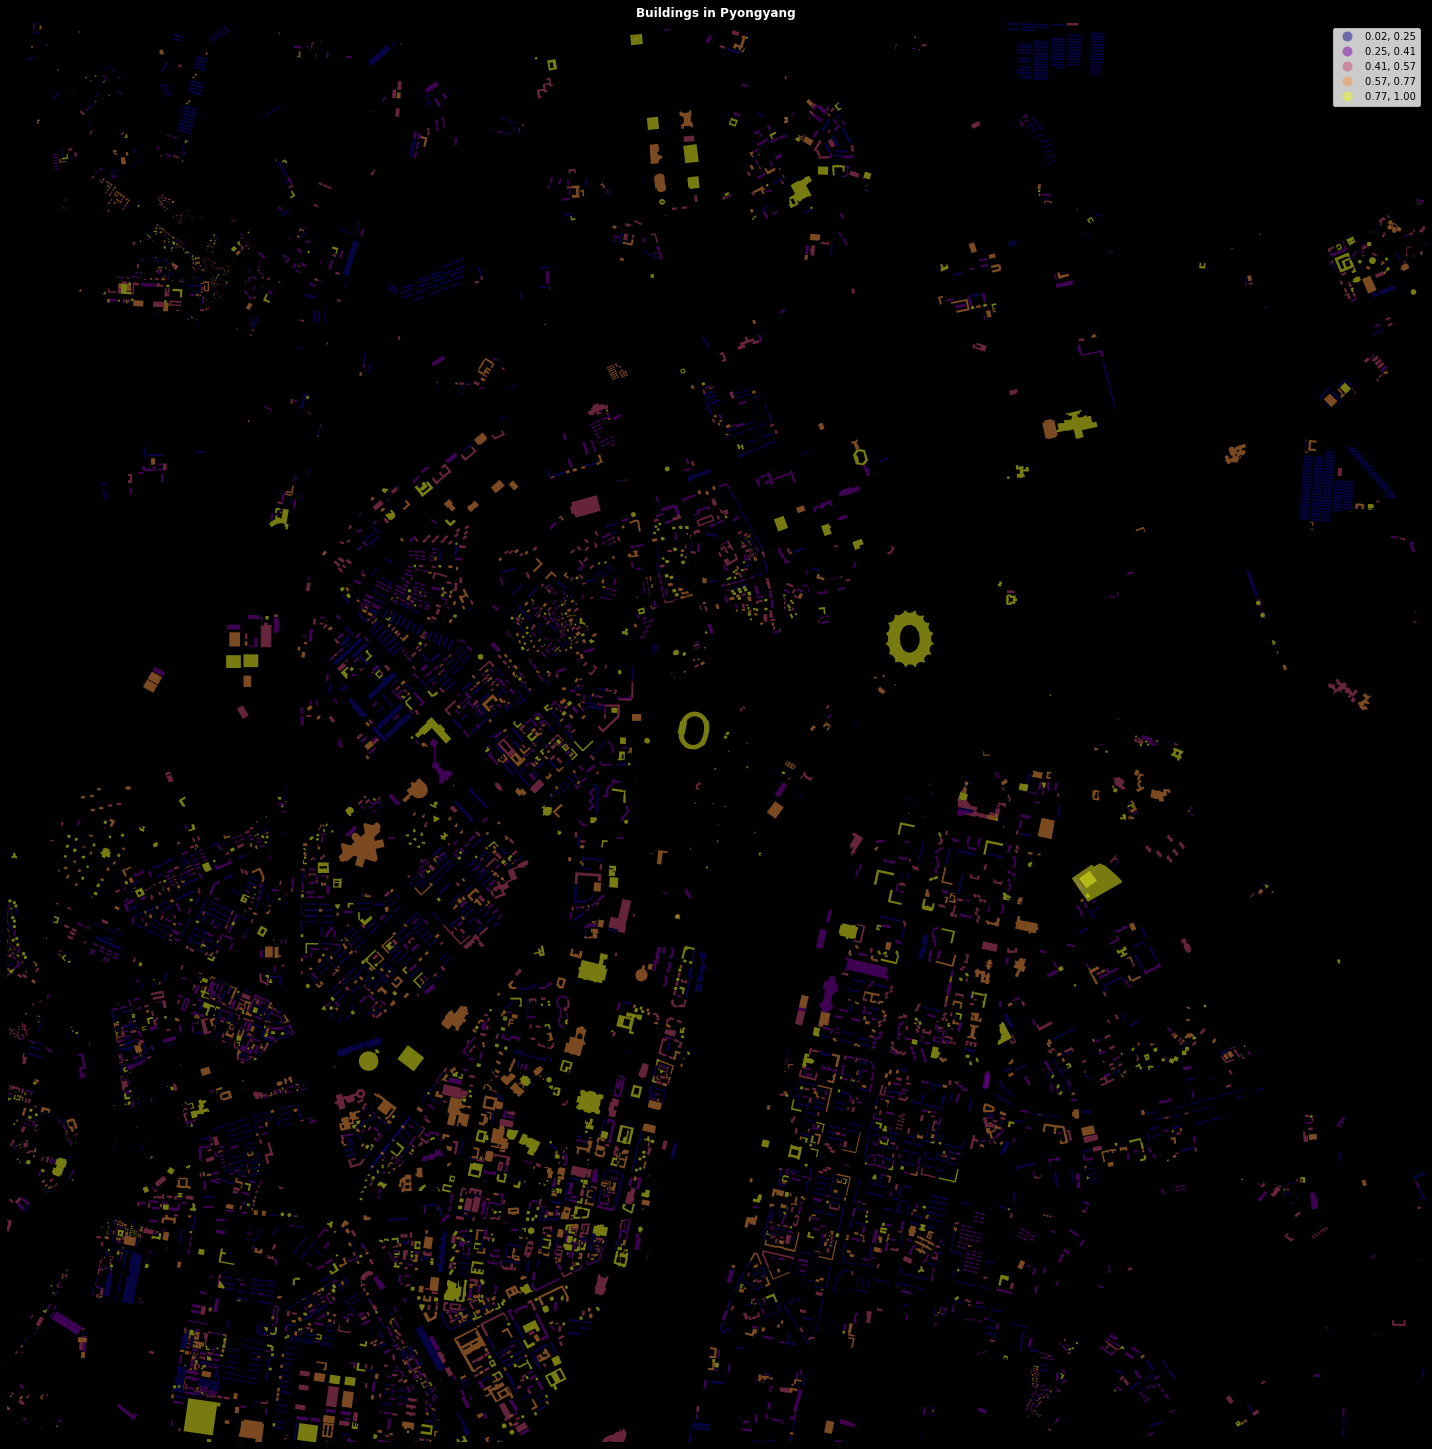

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

buildings.to_crs("epsg:4326").plot("elongation", ax=ax, cmap='plasma', alpha=0.5, scheme="natural_breaks", legend=True)
    
ax.set_title("Buildings in Pyongyang", color='w', weight='bold')

north, south, east, west = osmnx.utils_geo.bbox_from_point((buildings.geometry.to_crs("epsg:4326").centroid.y.mean(), 
                                                            buildings.geometry.to_crs("epsg:4326").centroid.x.mean()), 
                                                           dist=5000, project_utm=False, return_crs=False)

ax.set_ylim((south, north))
ax.set_xlim((west, east))

ax.margins(0)
ax.axis('off')
    
fig.savefig('urban-morphology-pyongyang-elongation.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')